In [97]:
import epics as ep
from time import sleep
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output, display
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
%matplotlib notebook

In [90]:
def getImg(cameraString,numshots):
    imagePV =cameraString+'FPICTURE'
    widthPV =cameraString+'WIDTH'
    heightPV =cameraString+'HEIGHT'

    width = int(ep.caget(widthPV))
    height = int(ep.caget(heightPV))
    tmp_Img = []
    for i in range(0,numshots):
        tmp_Img.append(ep.caget(imagePV)[0:height*width].reshape([height, width]))
        sleep(0.3)
    tmp_Img = np.asarray(tmp_Img)
    Img = {
        "images": tmp_Img,
        "x_profiles":tmp_Img.sum(axis=2),
        "y_profiles":tmp_Img.sum(axis=1),
        "x_profile":tmp_Img.mean(axis=0).sum(axis=1),
        "y_profile":tmp_Img.mean(axis=0).sum(axis=0),
        "mean": tmp_Img.mean(axis=0),
        "Camera name": cameraString,
        "Width": width,
        "Height": height,
    }
    return Img

def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

def getChannels(PV_channels):
    PV_values = []
    for ch in PV_channels:
        PV_values.append(ep.caget(ch))
    Set_energy = PSSS_energy_PV.get()
    
    return PV_values, Set_energy

def set_PSSS_energy(energy):
    PSSS_energy_PV.put(energy, wait=True)
    clear_output(wait=True)
    ! python /ioc/modules/qt/PSSS_motion.py -m1 SARFE10-PSSS059
    sleep(1)
    print(energy)

## define Channels

In [45]:
PSSS_energy_PV_name = 'SARFE10-PSSS059:ENERGY'
PSSS_energy_PV = ep.PV(PSSS_energy_PV_name)
PV_channels = ['SARFE10-PSSS055:MOTOR_X1.RBV','SARFE10-PSSS055:MOTOR_Y1.RBV','SARFE10-PSSS055:MOTOR_ROT_X1.RBV','SARFE10-PSSS055:MOTOR_PROBE.RBV','SARFE10-PSSS059:MOTOR_X2.RBV','SARFE10-PSSS059:MOTOR_X3.RBV','SARFE10-PSSS059:MOTOR_Y3.RBV','SARFE10-PSSS059:MOTOR_ROT_X3.RBV','SARFE10-PSSS059:MOTOR_Y4.RBV','SARFE10-PSSS059:MOTOR_ROT_X4.RBV','SARFE10-PSSS059:MOTOR_X5.RBV','SARFE10-PSSS059:MOTOR_Y5.RBV','SARFE10-PSSS059:MOTOR_Z5.RBV']
Cam_name = 'SARFE10-PSSS059:'

## Scan range

In [112]:
Start = PSSS_energy_PV.get()
Range = np.linspace(Start, Start+1000, 5)
num_shots = 10

In [113]:
PV_rbk = []
X_profile = []
Y_profile = []
for val in Range:
    set_PSSS_energy(val)
    sleep(5)
    set_PSSS_energy(Start)
    sleep(120)
    pvs_rbk, __ = getChannels(PV_channels)
    PV_rbk.append(pvs_rbk)
    img = getImg(Cam_name, num_shots)
    X_profile.append(img['x_profile'])
    Y_profile.append(img['y_profile'])

PV_rbk= np.asarray(PV_rbk)
X_profile= np.asarray(X_profile)
Y_profile= np.asarray(Y_profile)
delta_RBK = PV_rbk - PV_rbk[0,:]

energy2motor: camArmRot: 37.4427 cristBendRot: 19.3193 camPosX:-8.26981 evPerPix:0.03253
PSSS_motion done.
9995.0


In [117]:
Fit_centre_x = []
Fit_centre_y = []

for i in range(0, X_profile.shape[0]):
    Fit_centre_x.append(gauss_fit(np.arange(0,len(X_profile[i,:])),savgol_filter(X_profile[i,:],151,3))[2])
    Fit_centre_y.append(gauss_fit(np.arange(0,len(Y_profile[i,:])),savgol_filter(Y_profile[i,:],151,3))[2])    

<IPython.core.display.Javascript object>


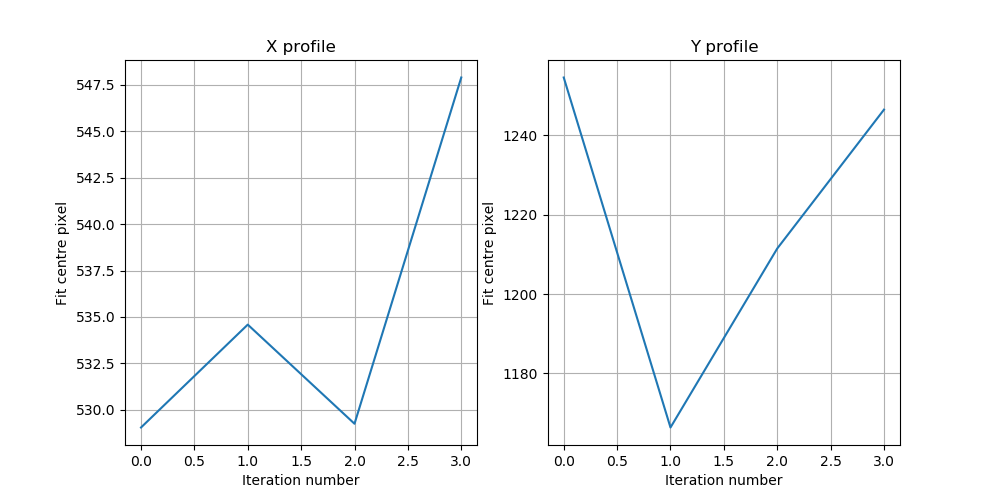

In [118]:
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.title('X profile')
plt.plot(Fit_centre_x[:-1])

plt.xlabel('Iteration number')
plt.ylabel('Fit centre pixel')
plt.grid(True)
plt.subplot(122)
plt.title('Y profile')

plt.plot(Fit_centre_y[:-1])
plt.xlabel('Iteration number')
plt.ylabel('Fit centre pixel')
plt.grid(True)

In [120]:
e_axis = ep.caget('SARFE10-PSSS059:SPECTRUM_X')

In [121]:
e_axis[20]-e_axis[0]

0.6503906

<IPython.core.display.Javascript object>


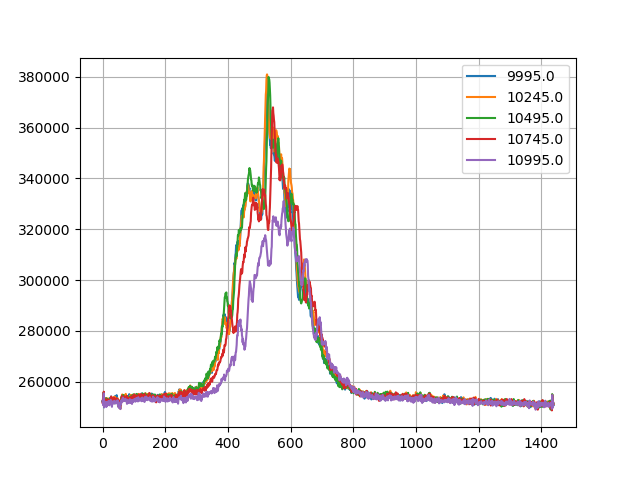

In [116]:
plt.figure()
for i in range(0, X_profile.shape[0]):
    plt.plot(X_profile[i,:], label = str(Range[i]))
plt.legend()
plt.grid(True)

In [122]:
delta_RBK

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])